See the accompanying discussion in the [guide](https://cityseer.benchmarkurbanism.com/guide).

## Setup

In [1]:
from cityseer import tools
import osmnx as ox
from shapely import geometry
import utm

# centre-point
lng, lat = -0.13396079424572427, 51.51371088849723

# select extents for plotting
easting, northing = utm.from_latlon(lat, lng)[:2]
buff = geometry.Point(easting, northing).buffer(1000)
min_x, min_y, max_x, max_y = buff.bounds


# reusable plot function
def simple_plot(_G):
    # plot using the selected extents
    tools.plot.plot_nx(_G,
                       labels=False,
                       plot_geoms=True,
                       node_size=15,
                       edge_width=2,
                       x_lim=(min_x, max_x),
                       y_lim=(min_y, max_y),
                       figsize=(20, 20),
                       dpi=200)


# Let's use OSMnx to fetch an OSM graph
# We'll use the same raw network for both workflows (hence simplify=False)
multi_di_graph_raw = ox.graph_from_point((lat, lng),
                                         dist=1250,
                                         simplify=False)

/Users/gareth/dev/cityseer-api/__pypackages__/3.10/lib/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

## Workflow 1

Cleaning the network with `osmnx`.

/Users/gareth/dev/cityseer-api/__pypackages__/3.10/lib/osmnx/simplification.py:499: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  subcluster_centroid = node_points.loc[wcc].unary_union.centroid
/Users/gareth/dev/cityseer-api/__pypackages__/3.10/lib/osmnx/simplification.py:500: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  gdf.loc[wcc, "x"] = subcluster_centroid.x
/Users/gareth/dev/cityseer-api/__pypackages__/3.10/lib/osmnx/simplification.py:501: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  gdf.loc[wcc, "y"] = subcluster_centroid.y
/Users/gareth/dev/cityseer-api/__pypackages__/3.10/lib/osmnx/simplification.py:503: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  gdf.loc[wcc, "cluster"] = f"{cluster_label}-{suffix}"
/U

<Figure size 432x288 with 0 Axes>

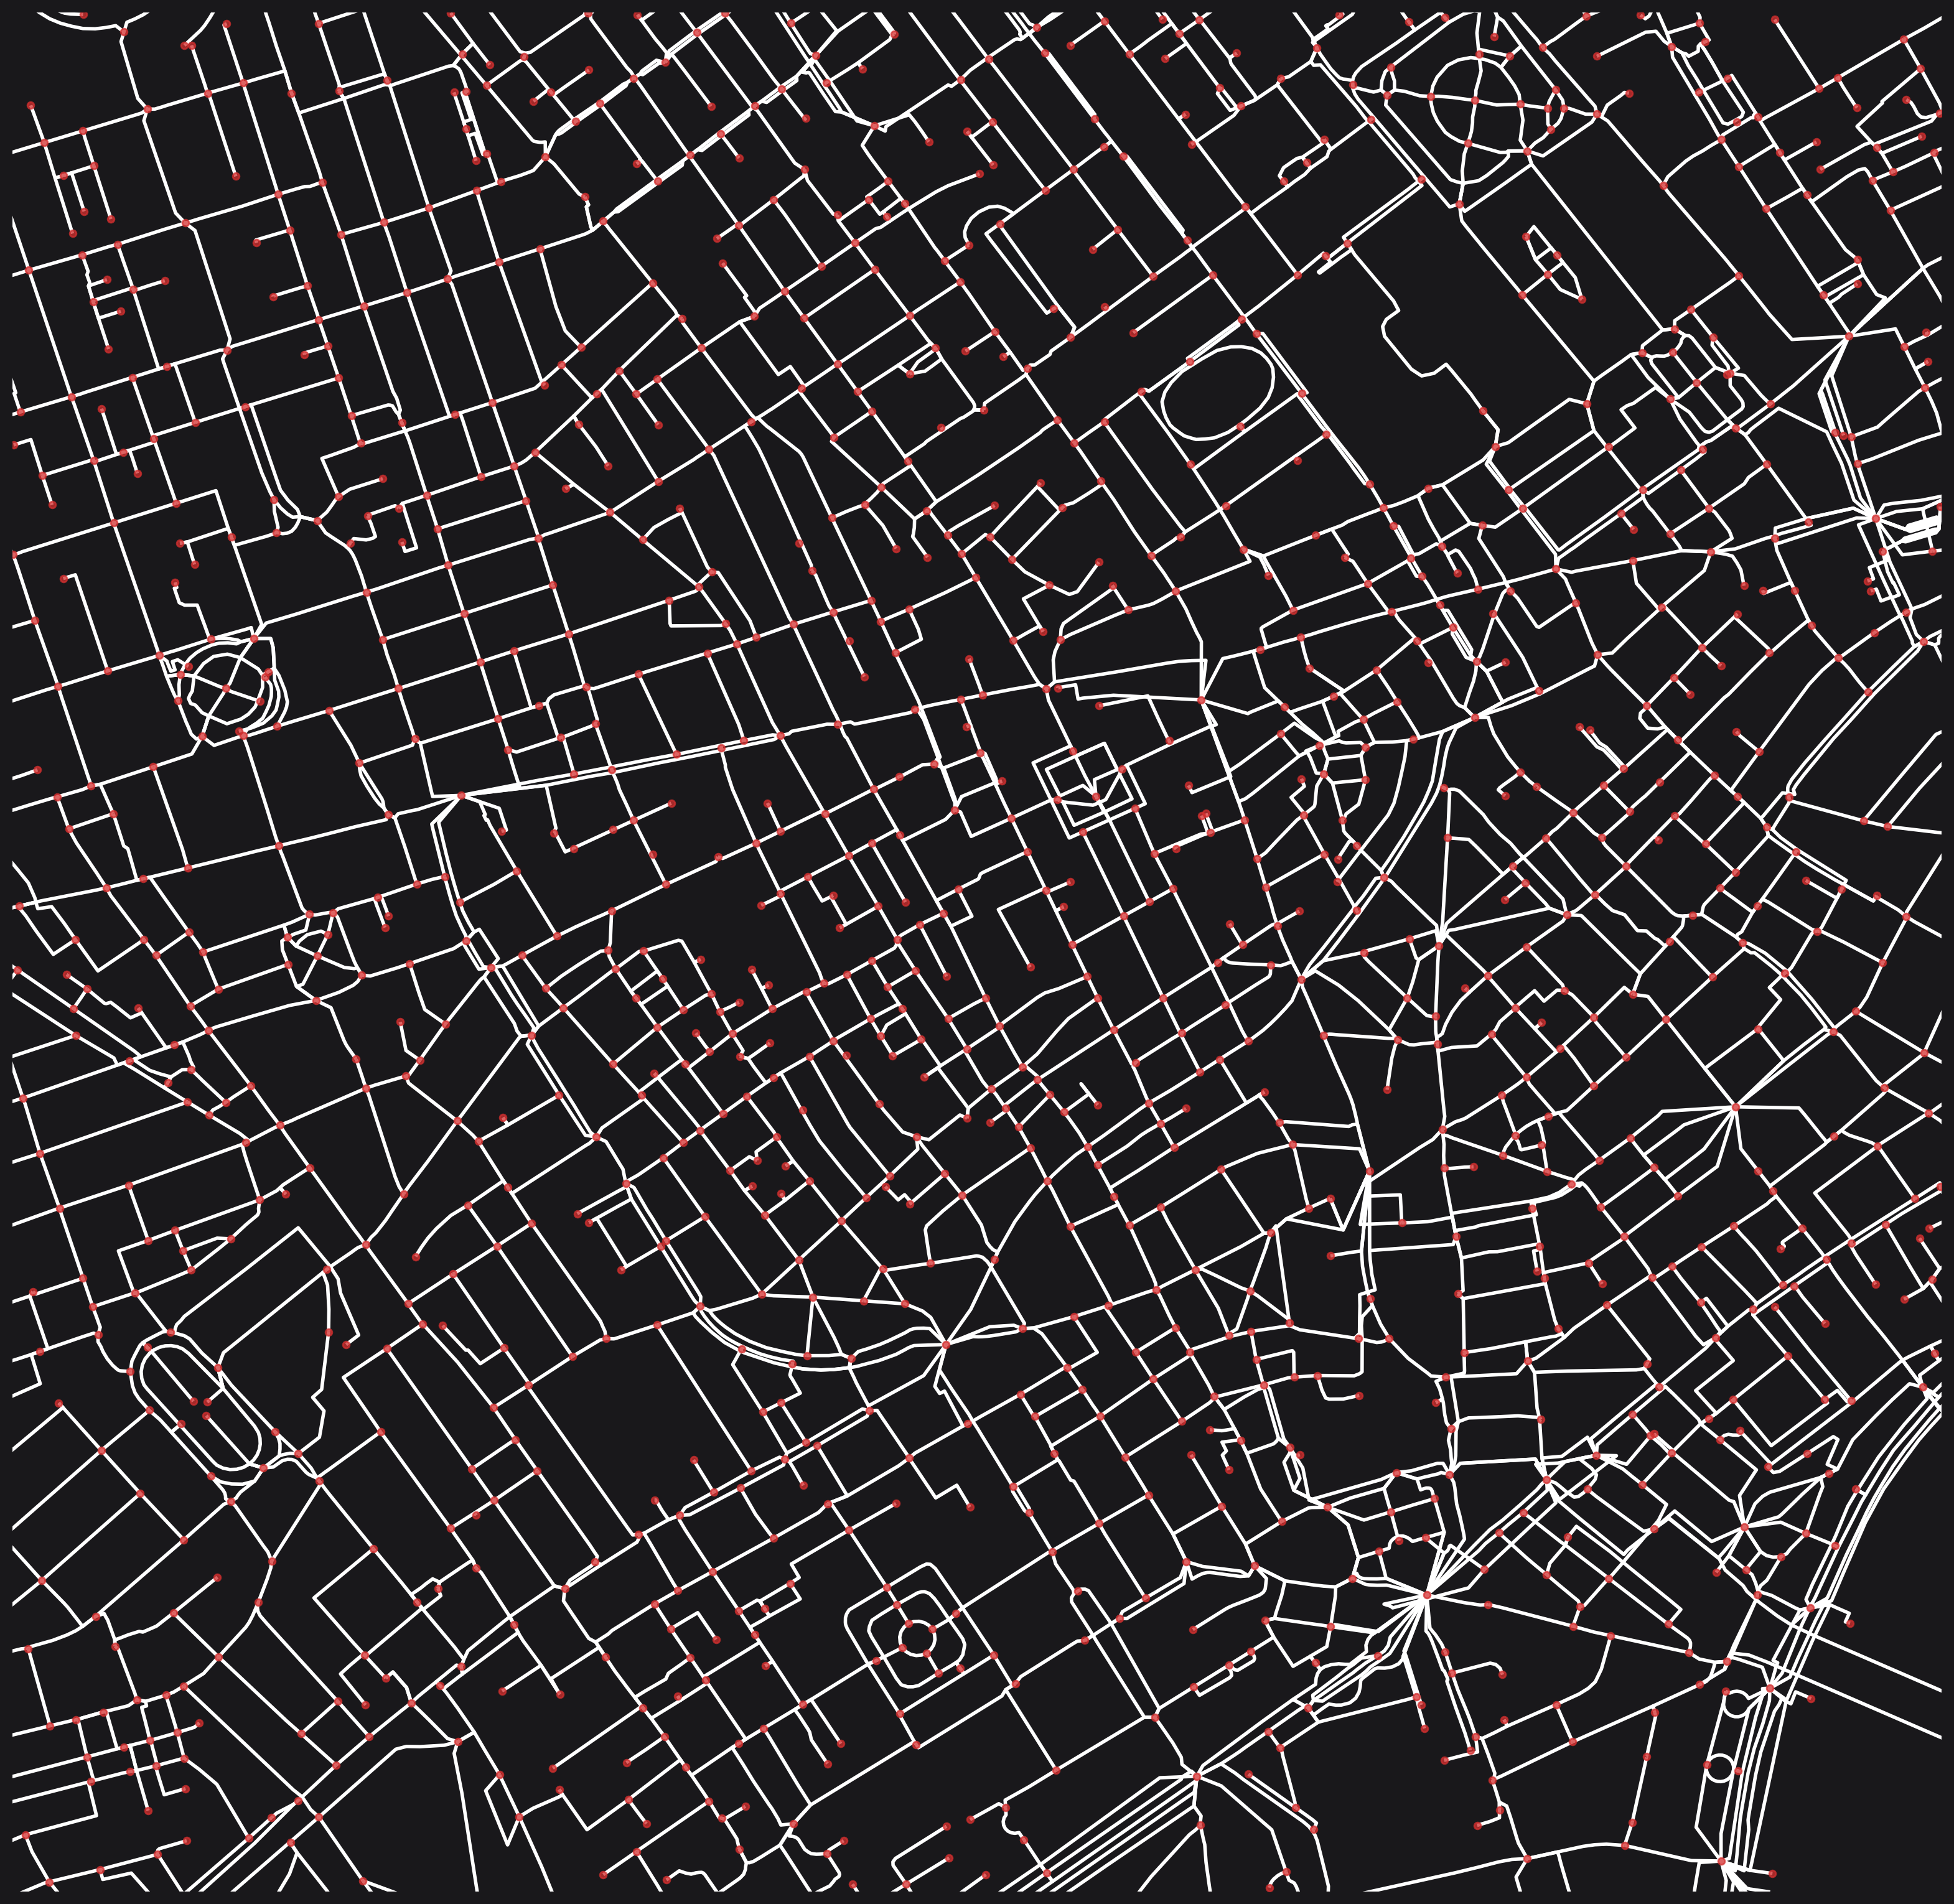

In [2]:
# Workflow 1: Using OSMnx to prepare the graph
# ============================================
# explicit simplification and consolidation via OSMnx
multi_di_graph_utm = ox.project_graph(multi_di_graph_raw)
multi_di_graph_simpl = ox.simplify_graph(multi_di_graph_utm)
multi_di_graph_cons = ox.consolidate_intersections(multi_di_graph_simpl,
                                                   tolerance=10,
                                                   dead_ends=True)
# let's use the same plotting function for both scenarios to aid visual comparisons
multi_graph_cons = tools.graphs.nx_from_osm_nx(multi_di_graph_cons, tolerance=50)
simple_plot(multi_graph_cons)

## Workflow 2

Converting an `osmnx` graph to `cityseer` before downstream processing.

INFO:cityseer.tools.graphs:Converting OSMnx MultiDiGraph to cityseer MultiGraph.
100%|██████████| 27331/27331 [00:02<00:00, 12810.44it/s]
INFO:cityseer.tools.graphs:Converting networkX graph from WGS to UTM.
INFO:cityseer.tools.graphs:Processing node x, y coordinates.
100%|██████████| 14310/14310 [00:00<00:00, 42640.94it/s]
INFO:cityseer.tools.graphs:Processing edge geom coordinates, if present.
100%|██████████| 16320/16320 [00:01<00:00, 15676.67it/s]
INFO:cityseer.tools.graphs:Generating simple (straight) edge geometries.
100%|██████████| 16320/16320 [00:00<00:00, 200380.68it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 14310/14310 [00:00<00:00, 20019.30it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████| 4732/4732 [00:00<00:00, 623212.44it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 4363/4363 [00:00<00:00, 184646.38it/s]
INFO:cityseer.tools.graphs:Consolidating nodes.
/Users/gareth/dev/cityseer-api/cityseer/tool

<Figure size 432x288 with 0 Axes>

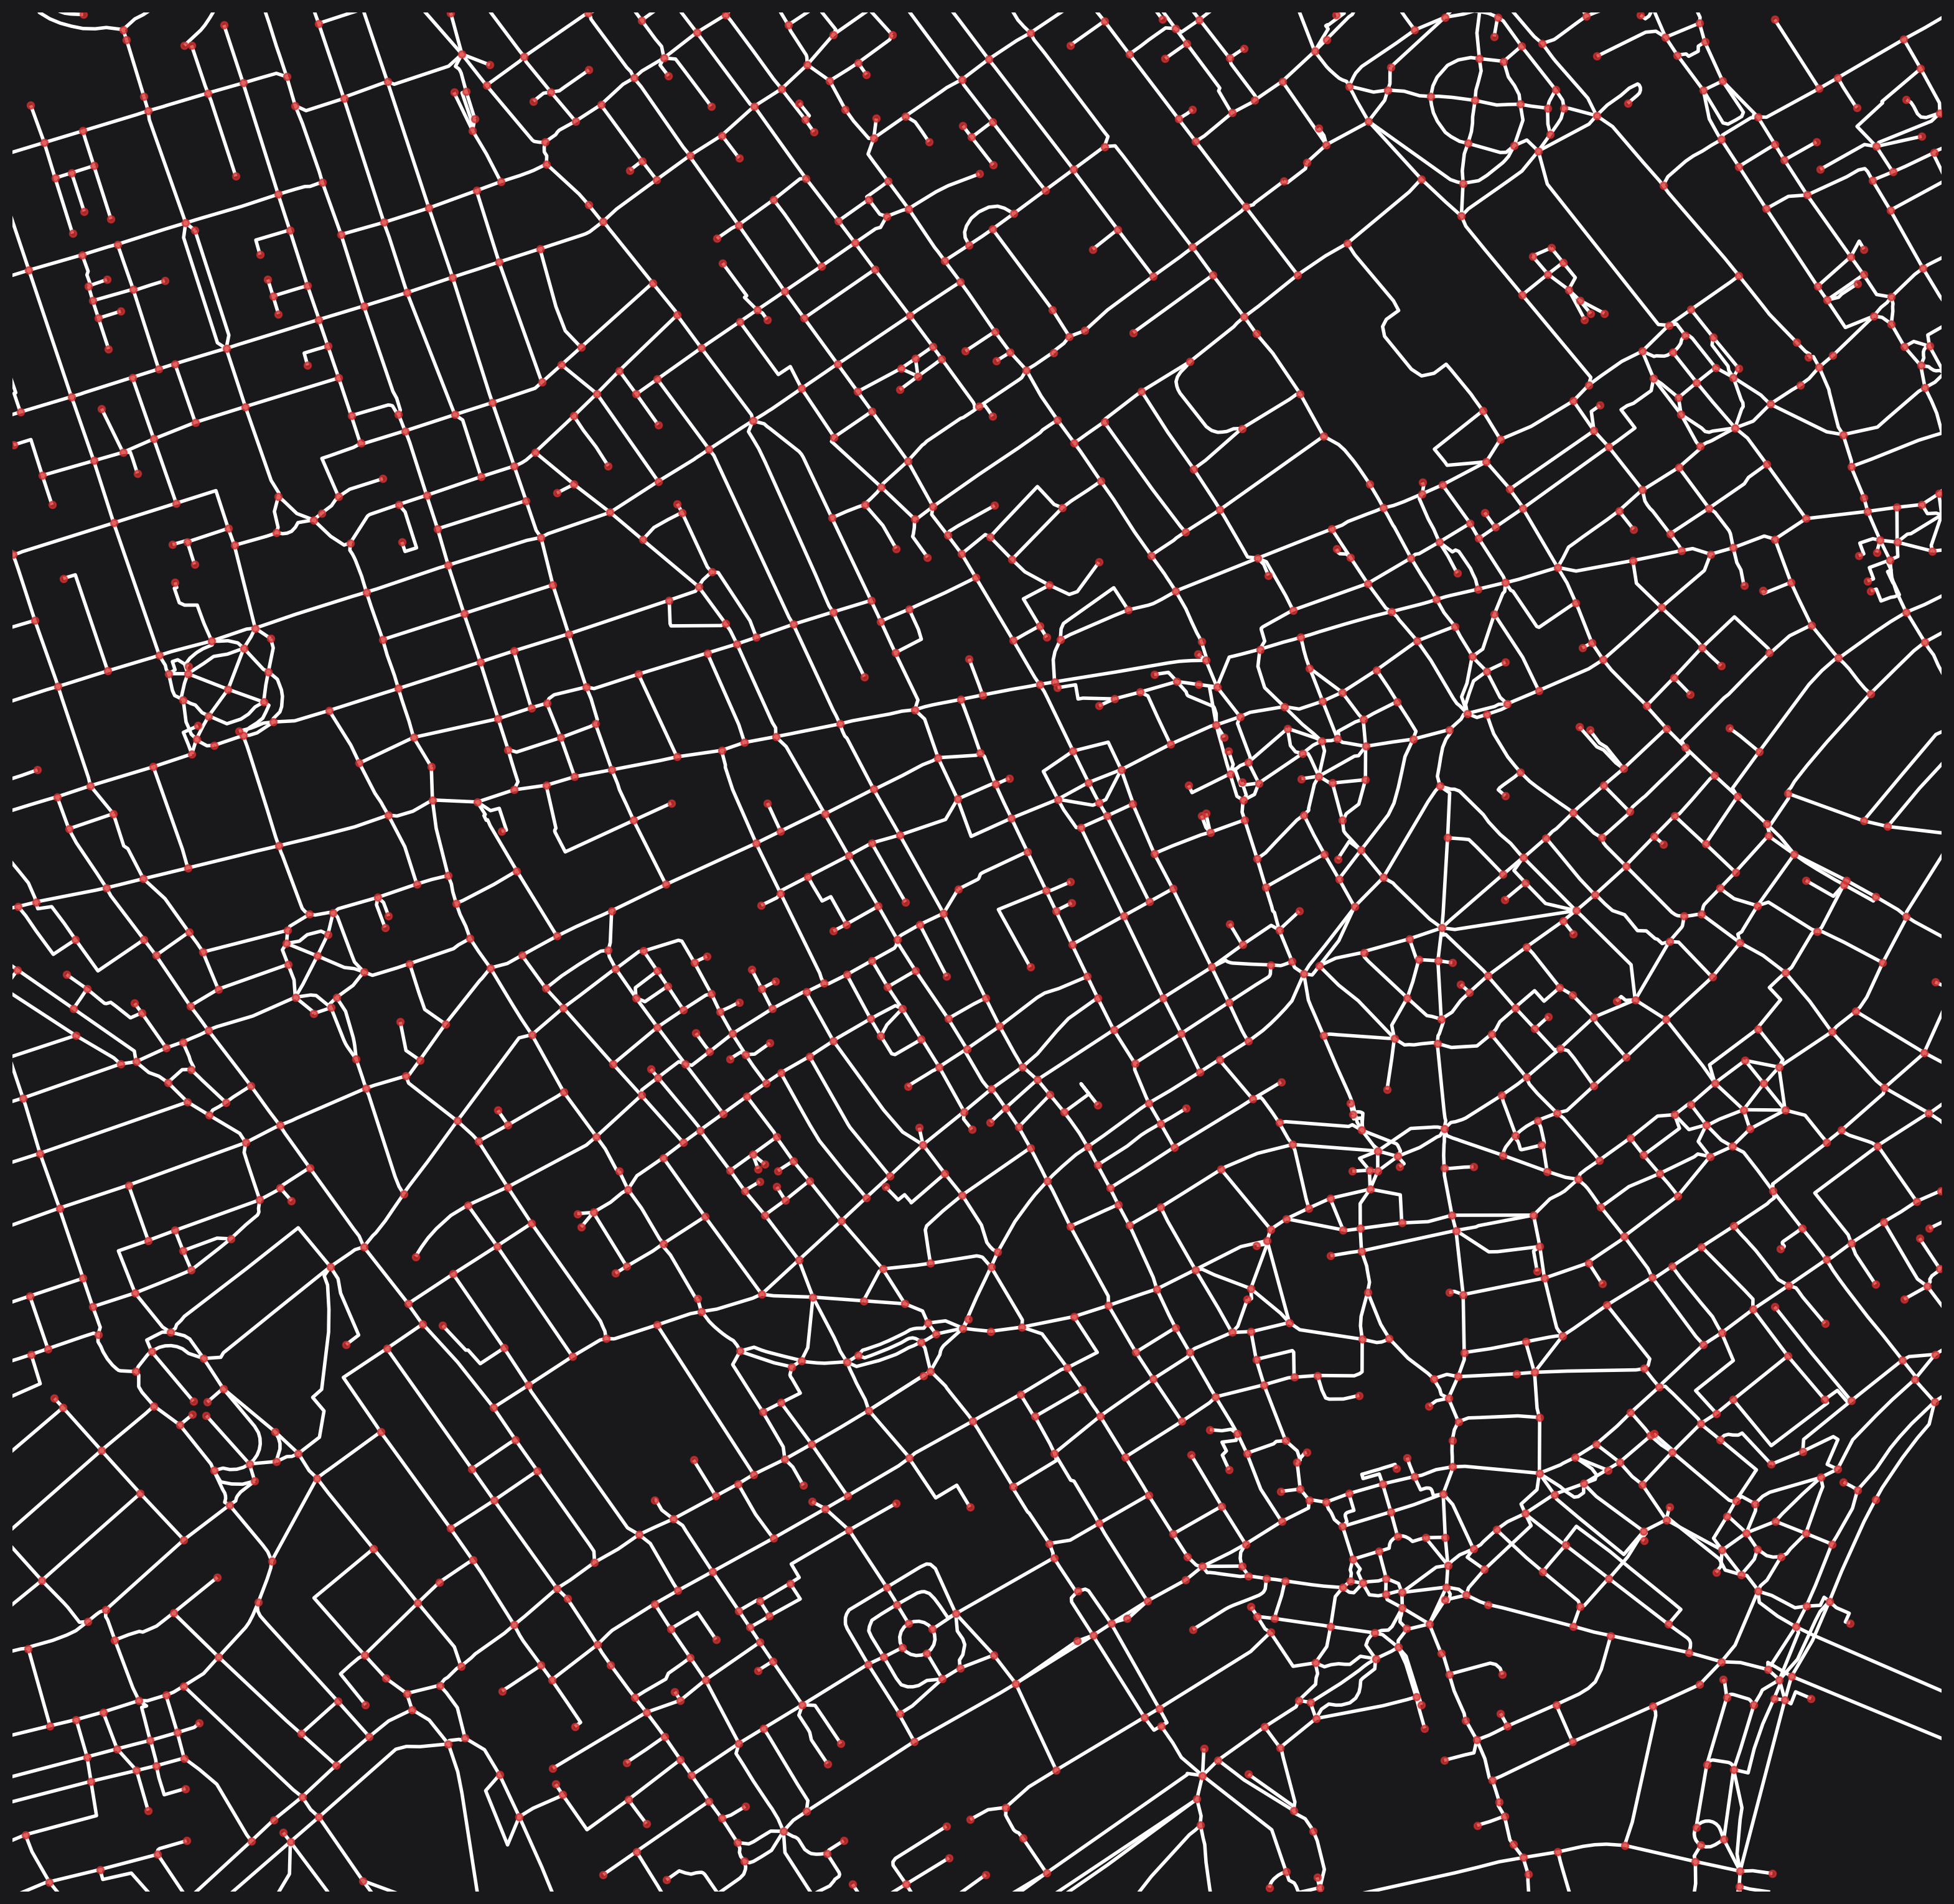

In [3]:
# WORKFLOW 2: Using cityseer to prepare the graph
# ===============================================
# let's convert the OSMnx graph to a cityseer compatible `multiGraph`
G_raw = tools.graphs.nx_from_osm_nx(multi_di_graph_raw)
# convert to UTM
G = tools.graphs.nx_wgs_to_utm(G_raw)
# infer geoms
G = tools.graphs.nx_simple_geoms(G)
# remove degree=2 nodes
G = tools.graphs.nx_remove_filler_nodes(G)
# remove dangling nodes
G = tools.graphs.nx_remove_dangling_nodes(G, despine=10)
# repeat degree=2 removal to remove orphaned nodes due to despining
G = tools.graphs.nx_remove_filler_nodes(G)
# let's consolidate the nodes
G1 = tools.graphs.nx_consolidate_nodes(G, buffer_dist=10, min_node_group=3)
# and we'll try to remove as many parallel roadways as possible
G2 = tools.graphs.nx_split_opposing_geoms(G1, buffer_dist=15)
G3 = tools.graphs.nx_consolidate_nodes(G2,
                                       buffer_dist=15,
                                       crawl=False,
                                       min_node_degree=2,
                                       cent_min_degree=4)
simple_plot(G3)